In [1]:
!pip install opendatasets -q

In [266]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

In [267]:
# Download dataset
od.download("https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images")

Skipping, found downloaded files in "./chest-ctscan-images" (use force=True to force download)


In [268]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [269]:
train_data_dir = "/content/chest-ctscan-images/Data/test"
test_data_dir = "/content/chest-ctscan-images/Data/train"
validation_data_dir = "/content/chest-ctscan-images/Data/valid"

train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 315 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 613 files belonging to 4 classes.


In [270]:
class_names = train_data.class_names
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [271]:
for image_batch,label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 128, 128, 3)
(32,)


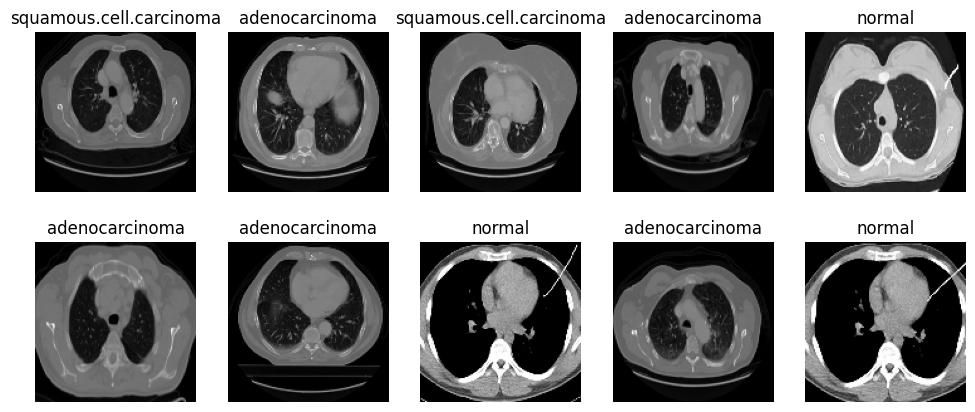

In [272]:
# plot data sample
plt.figure(figsize=(12,5))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [273]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)


tf.Tensor(
[[[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [1.0620117e-01 1.0620117e-01 1.0620117e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [3.5400391e-02 3.5400391e-02 3.5400391e-02]]

  [[1.5625000e-01 1.5625000e-01 1.5625000e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]]

  [[2.0751953e-02 2.0751953e-02 2.0751953e-02]
   [7.0556641e-02 7.0556641e-02 7.0556641e-02]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [5.3125000e-01 5.3125000e-01 5.3125000e-01]
   [2.0751953e-02 2.0751953e-02 2.0751953e-02]]

  ...

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00]
   [0.0000000e+

In [274]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

#**Transfer Learning**

In [275]:
pretrained_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3),
    pooling='max'
)

for layer in pretrained_model.layers:
        layer.trainable=False

In [276]:
# data_augmentation = tf.keras.Sequential(
#   [
#     tf.keras.layers.RandomFlip("horizontal",input_shape=(128,128,3)),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.2),
#   ]
# )

In [277]:
model = tf.keras.models.Sequential()

# model.add(data_augmentation)

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
# model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [278]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,730,788 (60.01 MB)

 Trainable params: 8,693,284 (33.16 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [279]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [280]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=11,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.3142 - loss: 4.8222 - val_accuracy: 0.3841 - val_loss: 1.7027
Epoch 2/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.4896 - loss: 1.3229 - val_accuracy: 0.4540 - val_loss: 1.5044
Epoch 3/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5314 - loss: 1.1249 - val_accuracy: 0.5079 - val_loss: 0.8806
Epoch 4/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.5826 - loss: 0.7888 - val_accuracy: 0.6667 - val_loss: 0.6776
Epoch 5/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.5885 - loss: 0.7369 - val_accuracy: 0.8000 - val_loss: 0.6122
Epoch 6/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.7561 - loss: 0.6026 - val_accuracy: 0.5841 - val_loss: 0.6814
Epoch 7/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.7229 - loss: 0.5416 - val_accuracy: 0.8286 - val_loss: 0.5036
Epoch 8/11
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.8141 - loss: 0.4967 - val_accuracy: 0.91

In [281]:
print(f'Total time for training {(end_time-start_time):.3f} seconds')

Total time for training 77.655 seconds


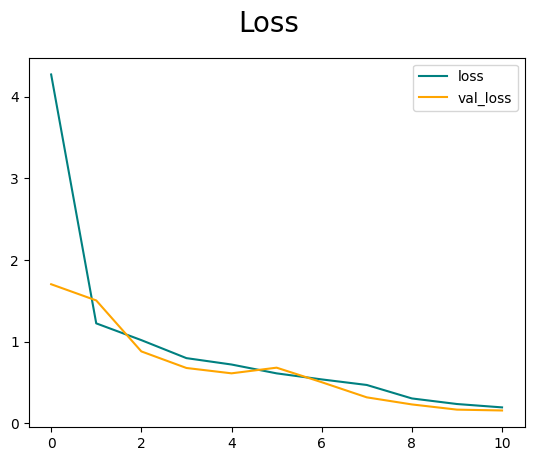

In [282]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

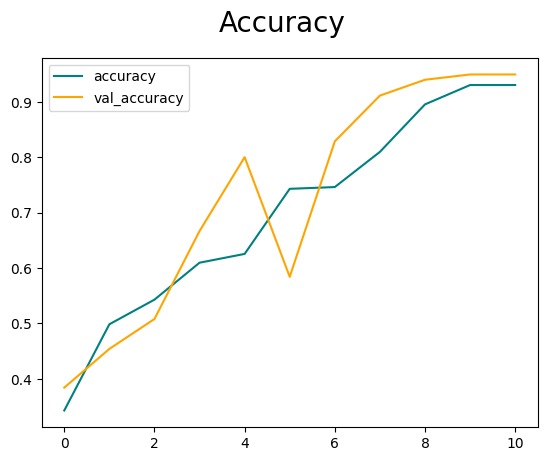

In [283]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

In [284]:
!pip install opencv-python -q

In [285]:
import cv2

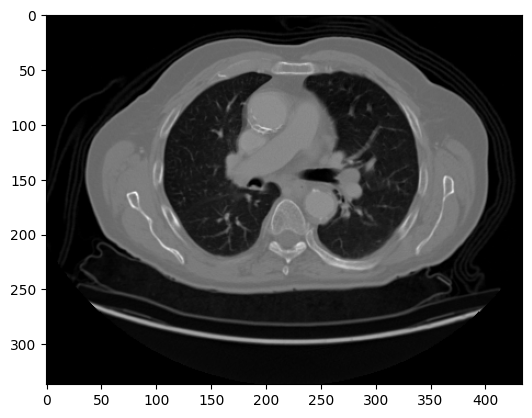

In [286]:
img = cv2.imread('/content/chest-ctscan-images/Data/test/squamous.cell.carcinoma/000112.png')
plt.imshow(img)
plt.show()

In [287]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255

In [288]:
scaled_image.shape

TensorShape([128, 128, 3])

In [289]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

In [290]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


In [291]:
yhat

array([[0.21404167, 0.02770104, 0.00083438, 0.75742286]], dtype=float32)

In [292]:
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

In [293]:
predicted_class_index = np.argmax(yhat)
predicted_class_name = class_names[predicted_class_index]
print(f"The predicted class is: {predicted_class_name}")

The predicted class is: squamous.cell.carcinoma


##Save Model

In [296]:
#Save Model as Keras
model.save("Chest_cancer_detection_model.keras")

In [298]:
#Save Model as h5
model.save("Chest_cancer_detection_model.h5")

##Load Model

In [307]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [308]:

#Using Keras
cancer_prediction_model = load_model('Chest_cancer_detection_model.keras')

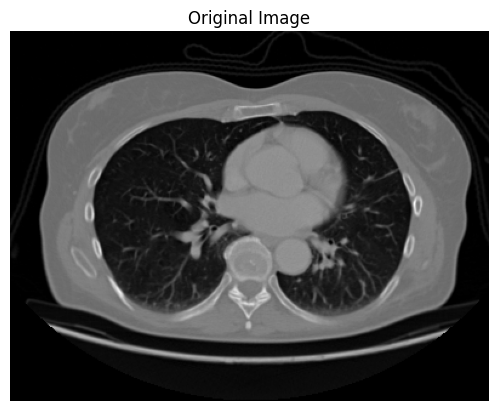

In [309]:
# Load the image
new_img_path = '/content/chest-ctscan-images/Data/test/large.cell.carcinoma/000111.png'
new_img = cv2.imread(new_img_path)
plt.imshow(new_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [310]:
# Preprocess the image
resized_new_img = tf.image.resize(new_img, IMAGE_SIZE)
scaled_new_img = resized_new_img/255.0
input_image = np.expand_dims(scaled_new_img, 0)

# Make a prediction
predictions = cancer_prediction_model.predict(input_image)

# Get the predicted class
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]

print(f"The predicted class for the new image is: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
The predicted class for the new image is: large.cell.carcinoma
